# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.datasets import get_rdataset
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# Load the Air Passenger dataset from statsmodels
dataset = get_rdataset("AirPassengers", "datasets")
data = dataset.data

# Reformat the data
data['Date'] = pd.date_range(start='1949-01', periods=len(data), freq='MS')  # 'MS' gives the first day of each month
data = data.rename(columns={'value': 'Passengers'})
data = data.drop(columns=['time']).set_index('Date')
display(data.head())

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Prepare Data

In [3]:
# Log transformation to stabilize variance
log_data = np.log(data)
log_data.head()

,Passengers
Date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


In [4]:
# First differencing to remove trend
diff_data = log_data.diff().dropna()
diff_data.head()

,Passengers
Date,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484


In [5]:
# Seasonal differencing to remove seasonality
seasonal_diff_data = diff_data.diff(12).dropna()
seasonal_diff_data.head()

,Passengers
Date,
1950-02-01,0.039164
1950-03-01,0.000361
1950-04-01,-0.020496
1950-05-01,-0.012939
1950-06-01,0.066148


In [6]:
# Create lag features (1 to 12 lags)
for lag in range(1, 13):
    seasonal_diff_data[f'lag_{lag}'] = seasonal_diff_data['Passengers'].shift(lag)
lag_data = seasonal_diff_data
lag_data.head()

,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date,,,,,,,,,,,,,
1950-02-01,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03-01,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-01,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-05-01,-0.012939,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-06-01,0.066148,-0.012939,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Create moving average features
window_sizes = [3, 6, 12]

for window in window_sizes:
    lag_data[f'ma_{window}'] = lag_data['Passengers'].rolling(window=window).mean()

ma_data = lag_data
ma_data.head()

,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,,
1950-02-01,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-03-01,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-01,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006343,NaN,NaN
1950-05-01,-0.012939,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011025,NaN,NaN
1950-06-01,0.066148,-0.012939,-0.020496,0.000361,0.039164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010905,NaN,NaN


In [8]:
# Final data
final_data = ma_data.dropna()
final_data.head()

,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,,
1951-02-01,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.039164,0.027515,0.005961,0.009063
1951-03-01,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.020689,0.013847,0.013922
1951-04-01,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,-0.014442,0.012875,0.011918
1951-05-01,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,0.048276,0.037896,0.023888
1951-06-01,-0.141343,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.018395,0.001147,0.006597


In [9]:
# Split data into train and test sets
train, test = final_data[:-24], final_data[-24:]
print("Training data:")
display(train.head())
print("\nTesting data:")
display(test.head())

Training data:


,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,,
1951-02-01,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.039164,0.027515,0.005961,0.009063
1951-03-01,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.020689,0.013847,0.013922
1951-04-01,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,-0.014442,0.012875,0.011918
1951-05-01,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,0.048276,0.037896,0.023888
1951-06-01,-0.141343,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.018395,0.001147,0.006597



Testing data:


,Passengers,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,,
1959-01-01,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,-0.021432,-0.017153,0.007720,0.000459,-0.001601
1959-02-01,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,-0.021432,0.018833,-0.000912,0.001485
1959-03-01,0.041950,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,0.037246,0.019118,0.008166
1959-04-01,0.014503,0.041950,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,0.024018,0.015869,0.010768
1959-05-01,0.016640,0.014503,0.041950,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,0.024364,0.021599,0.010297


In [10]:
# Define features and targets
X_train = train.drop(columns=['Passengers'])
y_train = train['Passengers']
X_test = test.drop(columns=['Passengers'])
y_test = test['Passengers']

# Display the data
print("Training features (past values):")
display(X_train.head())
print("\nTraining target (future values):")
display(y_train.head())
print("\nTesting features (past values):")
display(X_test.head())
print("\nTesting target (future values):")
display(y_test.head())

Training features (past values):


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,
1951-02-01,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.039164,0.027515,0.005961,0.009063
1951-03-01,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,0.000361,0.020689,0.013847,0.013922
1951-04-01,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,-0.020496,-0.014442,0.012875,0.011918
1951-05-01,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.012939,0.048276,0.037896,0.023888
1951-06-01,0.130705,-0.044548,0.058670,-0.057448,0.060844,0.079150,-0.019418,-0.038715,0.011354,0.000000,0.039915,0.066148,-0.018395,0.001147,0.006597



Training target (future values):


,Passengers
Date,
1951-02-01,-0.057448
1951-03-01,0.058670
1951-04-01,-0.044548
1951-05-01,0.130705
1951-06-01,-0.141343



Testing features (past values):


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_3,ma_6,ma_12
Date,,,,,,,,,,,,,,,
1959-01-01,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,-0.021432,-0.017153,0.007720,0.000459,-0.001601
1959-02-01,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,-0.021432,0.018833,-0.000912,0.001485
1959-03-01,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,-0.038228,0.037246,0.019118,0.008166
1959-04-01,0.041950,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,-0.016713,0.024018,0.015869,0.010768
1959-05-01,0.014503,0.041950,0.015601,0.054187,-0.013289,-0.017737,0.033998,-0.078229,0.023822,0.024066,0.008056,0.022285,0.024364,0.021599,0.010297



Testing target (future values):


,Passengers
Date,
1959-01-01,0.054187
1959-02-01,0.015601
1959-03-01,0.041950
1959-04-01,0.014503
1959-05-01,0.016640


In [11]:
# Isolate original series only
final_data_scaled = final_data[['Passengers']]
final_data_scaled.head()

,Passengers
Date,
1951-02-01,-0.057448
1951-03-01,0.058670
1951-04-01,-0.044548
1951-05-01,0.130705
1951-06-01,-0.141343


In [12]:
# Scaled version of the data
scaler = MinMaxScaler(feature_range=(0, 1)).set_output(transform='pandas')
final_data_scaled = scaler.fit_transform(final_data_scaled)
final_data_scaled = final_data_scaled['Passengers']
final_data_scaled.head()

,Passengers
Date,
1951-02-01,0.297434
1951-03-01,0.709109
1951-04-01,0.343169
1951-05-01,0.964495
1951-06-01,0.000000


In [13]:
# Split the scaled data
train_scaled, test_scaled = final_data_scaled[:-24], final_data_scaled[-24:]
print("Scaled training data:")
display(train_scaled.head())
print("\nScaled testing data:")
display(test_scaled.head())

Scaled training data:


,Passengers
Date,
1951-02-01,0.297434
1951-03-01,0.709109
1951-04-01,0.343169
1951-05-01,0.964495
1951-06-01,0.000000



Scaled testing data:


,Passengers
Date,
1959-01-01,0.693214
1959-02-01,0.556416
1959-03-01,0.649830
1959-04-01,0.552522
1959-05-01,0.560100


# XGBoost Recursive Forecasting

In [14]:
# Train the XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Initialize predictions list and last known values
predictions = []
last_known_values = X_test.iloc[0, :].values  # First row of X_test as initial input

# Predict each value in the test set
for _ in range(len(test)):
    next_pred = model.predict([last_known_values])[0]  # Predict next value
    predictions.append(next_pred)

    # Update lagged features for next prediction
    last_known_values = np.roll(last_known_values, shift=1)  # Shift values right
    last_known_values[0] = next_pred  # Set first value to the predicted value

# Convert predictions to DataFrame
predictions = pd.DataFrame(predictions, index=test.index, columns=['Passengers'])
predictions.head()

,Passengers
Date,
1959-01-01,0.016861
1959-02-01,-0.022200
1959-03-01,-0.011360
1959-04-01,-0.008699
1959-05-01,-0.037998


In [16]:
# Function to inverse the differencing process
def inverse_diff(series, last_observation):
    series_undifferenced = series.copy()
    series_undifferenced.iat[0] = series_undifferenced.iat[0] + last_observation
    series_undifferenced = series_undifferenced.cumsum()
    return series_undifferenced

# Step 1: Undo the seasonal differencing
# Last observation before the seasonal differencing
last_seasonal_value = train['Passengers'].iloc[-12]
inverse_seasonal = inverse_diff(predictions['Passengers'], last_seasonal_value)

# Step 2: Undo the first differencing
# Last observation before the first differencing
last_first_diff_value = log_data['Passengers'].iloc[-1]
inverse_diff = inverse_diff(inverse_seasonal, last_first_diff_value)

# Step 3: Undo the log transformation
inverse_log = np.exp(inverse_diff)

# Convert to DataFrame
final_pred = pd.DataFrame(inverse_log, index=test.index, columns=['Passengers'])

# Display the inverse-transformed predictions
display(final_pred.head())

,Passengers
Date,
1959-01-01,431.874038
1959-02-01,422.268758
1959-03-01,408.213550
1959-04-01,391.208335
1959-05-01,360.933000


In [17]:
# Plotting function
def plot_predictions(test_data, predictions, target_column='Passengers'):
    """
    Plots the actual test data and the predictions.

    Parameters:
    - test_data: DataFrame containing the actual test data.
    - predictions: DataFrame containing the predictions.
    - target_column: The name of the target column in the data (default is 'Passengers').
    """
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data[target_column], label='Actual', color='dodgerblue')
    plt.plot(predictions.index, predictions[target_column], label='Predicted', color='red')
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.legend()
    plt.grid(True)
    plt.show()

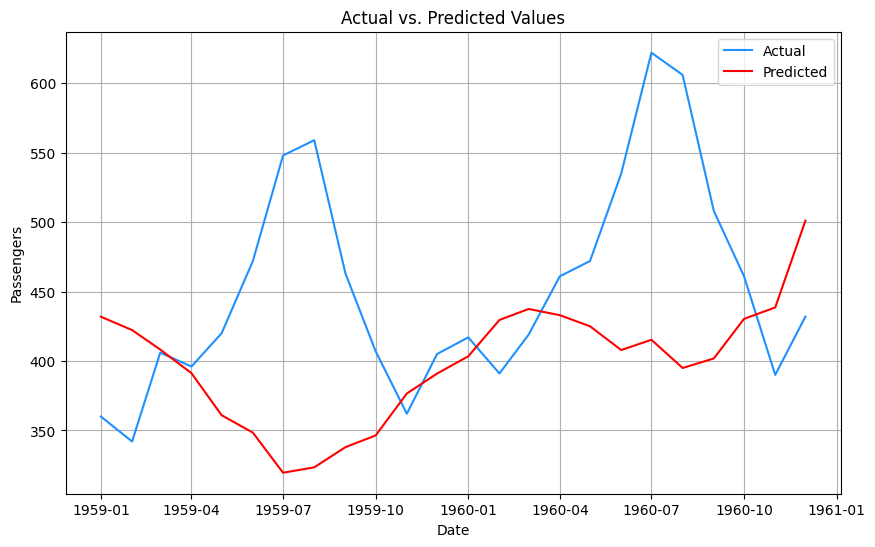

In [18]:
# Plot the test data and predictions
original_test_data = data[-24:]
plot_predictions(original_test_data, final_pred)

In [19]:
# Calculate metrics
mape = mean_absolute_percentage_error(original_test_data, final_pred)
mae = mean_absolute_error(original_test_data, final_pred)
mse = mean_squared_error(original_test_data, final_pred)
rmse = np.sqrt(mse)

# Create dictionary
metrics_dict = {
    'MAPE': mape,
    'MAE': mae,
    'MSE': mse,
    'RMSE': rmse
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Value']).T
metrics_df.index.name = 'Metric'
metrics_df = metrics_df.round(3)
display(metrics_df)

,Value
Metric,
MAPE,0.167
MAE,81.883
MSE,11900.152
RMSE,109.088


# ARIMA Recursive Forecasting

In [20]:
# Define and fit the ARIMA model on the training data
arima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
arima_model = ARIMA(y_train, order=arima_order, seasonal_order=seasonal_order)
arima_model_fit = arima_model.fit()

In [21]:
# Initialize a list to hold predictions
predictions = []

# Start with the last observation of the training data
extended_series = y_train.copy()

# Recursive forecasting
for i in range(len(y_test)):
    # Forecast the next value
    next_pred = arima_model_fit.forecast(steps=1)[0]
    predictions.append(next_pred)

    # Update the model with the new prediction
    arima_model_fit = arima_model_fit.append([next_pred])

# Convert predictions to a DataFrame
predictions = pd.DataFrame(predictions, index=y_test.index, columns=['Passengers'])
predictions.head()

,Passengers
Date,
1959-01-01,0.004379
1959-02-01,-0.018715
1959-03-01,0.015080
1959-04-01,0.008602
1959-05-01,0.005257


In [22]:
# Function to perform inverse transformations
def inverse_transform_forecast(predictions, train_data, log_data, diff_order=1, seasonal_diff_order=12):
    """
    Inverses the differencing and log transformation on the predicted time series data.

    Parameters:
    - predictions: Series or DataFrame of predicted values after differencing and log transformation.
    - train_data: Series or DataFrame of the original training data before differencing.
    - log_data: Series or DataFrame of the log-transformed data before differencing.
    - diff_order: Integer, the order of the first differencing applied (default is 1).
    - seasonal_diff_order: Integer, the seasonal differencing period (default is 12).

    Returns:
    - final_pred: DataFrame of predictions transformed back to the original scale.
    """
    # Function to undo differencing
    def inverse_diff(series, last_observation):
        series_undifferenced = series.copy()
        series_undifferenced.iat[0] = series_undifferenced.iat[0] + last_observation
        series_undifferenced = series_undifferenced.cumsum()
        return series_undifferenced

    # Step 1: Undo the seasonal differencing
    last_seasonal_value = train_data.iloc[-seasonal_diff_order]
    inverse_seasonal = inverse_diff(predictions, last_seasonal_value)

    # Step 2: Undo the first differencing
    last_first_diff_value = log_data.iloc[-diff_order]
    inverse_diff_series = inverse_diff(inverse_seasonal, last_first_diff_value)

    # Step 3: Undo the log transformation
    inverse_log = np.exp(inverse_diff_series)

    # Convert to DataFrame
    final_pred = pd.DataFrame(inverse_log, index=predictions.index, columns=['Passengers'])

    return final_pred

In [23]:
# Inverse transformations
final_pred = inverse_transform_forecast(predictions['Passengers'], train['Passengers'], log_data['Passengers'])
display(final_pred.head())

,Passengers
Date,
1959-01-01,426.516719
1959-02-01,413.295177
1959-03-01,406.568583
1959-04-01,403.406756
1959-05-01,402.379150


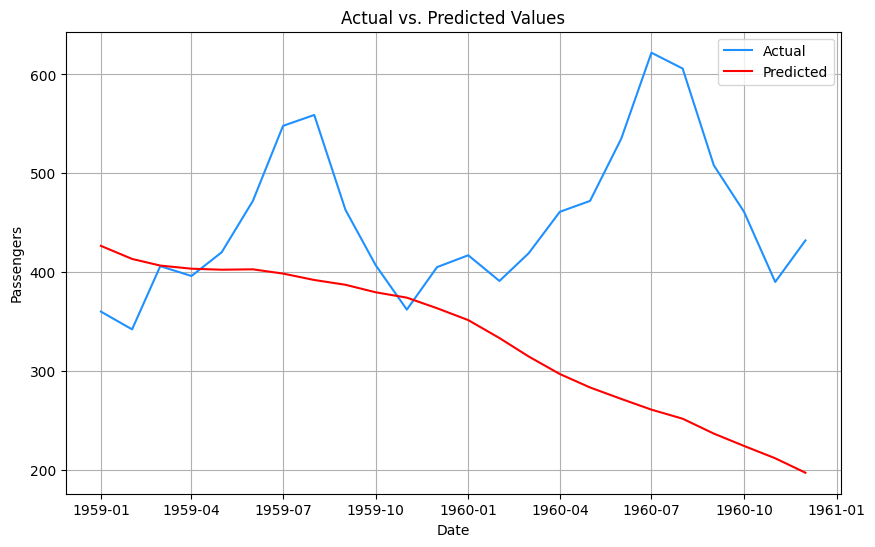

In [24]:
# Plot the test data and predictions
original_test_data = data[-24:]
plot_predictions(original_test_data, final_pred)

In [25]:
# Function to calculate metrics
def calculate_forecast_metrics(true_values, predicted_values):
    """
    Calculates evaluation metrics for forecast predictions and returns them as a DataFrame.

    Parameters:
    - true_values: Series or DataFrame containing the actual values.
    - predicted_values: Series or DataFrame containing the predicted values.

    Returns:
    - metrics_df: DataFrame with calculated metrics (MAPE, MAE, MSE, RMSE) rounded to three decimal places.
    """
    # Calculate metrics
    mape = mean_absolute_percentage_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)

    # Create dictionary of metrics
    metrics_dict = {
        'MAPE': mape,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

    # Convert dictionary to DataFrame
    metrics_df = pd.DataFrame(metrics_dict, index=['Value']).T
    metrics_df.index.name = 'Metric'
    metrics_df = metrics_df.round(3)

    return metrics_df

In [26]:
# Calculate metrics
metrics_df = calculate_forecast_metrics(original_test_data['Passengers'], final_pred['Passengers'])
display(metrics_df)

,Value
Metric,
MAPE,0.273
MAE,132.839
MSE,29039.445
RMSE,170.410


# LSTM Recursive Forecasting

In [27]:
# Specify the number of lags
lags = 12

# Prepare the data for LSTM
X_train, y_train = [], []

for i in range(lags, len(train_scaled)):
    X_train.append(train_scaled[i-lags:i].values)
    y_train.append(train_scaled[i])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape X_train for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [28]:
# Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

In [29]:
# Initialize the history
history = list(train_scaled[-lags:].values.flatten())  # Start with the last `lags` values from the training set
predictions = []

# Perform recursive forecasting
for i in range(len(test_scaled)):
    # Prepare the input for the LSTM model
    X_test = np.array(history[-lags:]).reshape(1, lags, 1)

    # Predict the next value
    next_pred = model.predict(X_test, verbose=0)[0][0]
    predictions.append(next_pred)

    # Append the prediction to the history
    history.append(next_pred)

# Convert predictions to a DataFrame
predictions = pd.DataFrame(predictions, index=y_test.index, columns=['Passengers'])
predictions.head()

,Passengers
Date,
1959-01-01,0.485365
1959-02-01,0.486210
1959-03-01,0.487532
1959-04-01,0.490583
1959-05-01,0.491124


In [30]:
# Inverse scaling
predictions = scaler.inverse_transform(predictions)
predictions = pd.DataFrame(predictions, index=y_test.index, columns=['Passengers'])
predictions.head()

,Passengers
Date,
1959-01-01,-0.004440
1959-02-01,-0.004202
1959-03-01,-0.003829
1959-04-01,-0.002968
1959-05-01,-0.002815


In [31]:
# Inverse transformations
final_pred = inverse_transform_forecast(predictions['Passengers'], train['Passengers'], log_data['Passengers'])
display(final_pred.head())

,Passengers
Date,
1959-01-01,422.771898
1959-02-01,412.006233
1959-03-01,399.980371
1959-04-01,387.154688
1959-05-01,373.686746


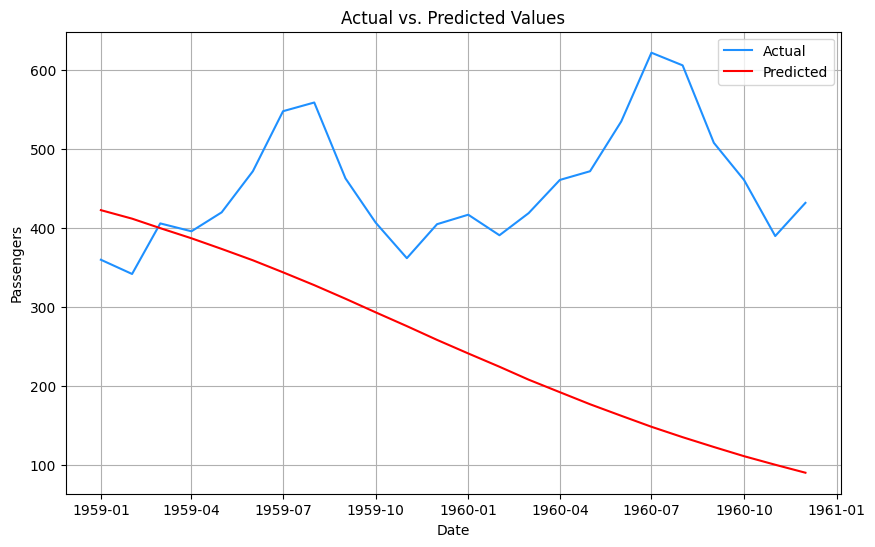

In [32]:
# Plot the test data and predictions
original_test_data = data[-24:]
plot_predictions(original_test_data, final_pred)

In [33]:
# Calculate metrics
metrics_df = calculate_forecast_metrics(original_test_data['Passengers'], final_pred['Passengers'])
display(metrics_df)

,Value
Metric,
MAPE,0.442
MAE,209.922
MSE,62534.627
RMSE,250.069
